# **Deep learning for dynamic network analysis (DLDNA) - Final project**
**Dolphins:** R. ARNAUD M. DELPLANQUE A. KARILA-COHEN A. RAMPOLDI <br> **Dataset:** Comprehensive soil classification dataset: https://www.kaggle.com/datasets/ai4a-lab/comprehensive-soil-classification-datasets/code

_______________

# Notebook 4 — Comparative Analysis of Deep Learning Architectures

This notebook consolidates and compares the results obtained from all previous experiments, providing a global assessment of the proposed deep learning approaches for soil classification.

> ### Compared Approaches
> The following models and training strategies are evaluated:
> - **CNN (baseline)**: Convolutional neural network trained on the original dataset.
> - **CNN + cGAN**: CNN trained with data augmented using a Conditional GAN.
> - **CNN + StarGAN**: CNN trained with multi-domain augmented data generated by StarGAN.
> - **Transformer (baseline)**: Swin Transformer leveraging self-attention mechanisms for global feature extraction.
> - **Transformer + GAN augmentation**: Transformer trained using GAN- or StarGAN-augmented datasets.
>
> ### Evaluation Criteria
> Models are compared using the following metrics and analyses:
> - Overall classification accuracy,
> - Confusion matrices for class-wise performance,
> - Generalization behavior on the test set,
> - Sensitivity to class imbalance and minority classes.

### Objective
The objectives of this comparative study are to:
- Identify the most effective architecture for soil image classification,
- Assess the impact of generative data augmentation strategies,
- Analyze trade-offs between model complexity, performance, and robustness.

### Outcome
The results presented in this notebook form the basis for the final discussion and conclusions of the report, highlighting the strengths and limitations of each approach in a geotechni


______

# Model Comparison Results

This notebook compares the performance of different models:
- **CNN**: Simple Convolutional Neural Network
- **Transformer**: Swin Transformer (Attention Mechanism)
- **GAN**: CNN with Conditional GAN Data Augmentation
- **StarGAN**: Results from StarGAN experiments

_____

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import re
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## 2. Load Results from All Models

In [2]:
# Define paths
project_root = Path('..')
results_root = project_root / 'results'
comparison_root = results_root / 'comparison'
comparison_root.mkdir(parents=True, exist_ok=True)

# Define model folders
model_folders = {
    'CNN': results_root / 'CNN',
    'Transformer': results_root / 'Attention',
    'GAN': results_root / 'GAN',
    'StarGAN': results_root / 'StarGAN'
}

# Check which models have results
available_models = {}
for model_name, folder_path in model_folders.items():
    if folder_path.exists() and any(folder_path.iterdir()):
        available_models[model_name] = folder_path
        print(f"✓ {model_name}: Results found at {folder_path}")
    else:
        print(f"✗ {model_name}: No results found at {folder_path}")

print(f"\nTotal models with results: {len(available_models)}")

✓ CNN: Results found at ..\results\CNN
✓ Transformer: Results found at ..\results\Attention
✓ GAN: Results found at ..\results\GAN
✓ StarGAN: Results found at ..\results\StarGAN

Total models with results: 4


## 3. Parse Performance Metrics from Text Files

In [3]:
def load_cnn_metrics(folder_path):
    """Load CNN metrics from JSON file."""
    metrics_file = folder_path / 'metrics.json'
    if metrics_file.exists():
        with open(metrics_file, 'r') as f:
            data = json.load(f)
        return {
            'accuracy': data.get('accuracy', 0) / 100 if data.get('accuracy', 0) > 1 else data.get('accuracy', 0),
            'precision': data.get('precision', 0),
            'recall': data.get('recall', 0),
            'f1_score': data.get('f1_score', 0)
        }
    return None

def load_gan_metrics(folder_path):
    """Load GAN metrics from text file."""
    metrics_file = folder_path / 'overall_metrics.txt'
    if metrics_file.exists():
        with open(metrics_file, 'r') as f:
            content = f.read()
        
        metrics = {}
        # Extract accuracy (format: "Accuracy:  71.4286 (7142.86%)")
        acc_match = re.search(r'Accuracy:\s+(\d+\.?\d*)', content)
        if acc_match:
            metrics['accuracy'] = float(acc_match.group(1)) / 100
        
        # Extract precision
        prec_match = re.search(r'Precision:\s+(\d+\.?\d*)', content)
        if prec_match:
            metrics['precision'] = float(prec_match.group(1))
        
        # Extract recall
        recall_match = re.search(r'Recall:\s+(\d+\.?\d*)', content)
        if recall_match:
            metrics['recall'] = float(recall_match.group(1))
        
        # Extract F1
        f1_match = re.search(r'F1-Score:\s+(\d+\.?\d*)', content)
        if f1_match:
            metrics['f1_score'] = float(f1_match.group(1))
        
        return metrics if metrics else None
    return None

def load_transformer_metrics(folder_path):
    """Load Transformer metrics from evaluation report."""
    metrics_file = folder_path / 'evaluation_report.txt'
    if metrics_file.exists():
        with open(metrics_file, 'r') as f:
            content = f.read()
        
        metrics = {}
        # Extract total accuracy
        acc_match = re.search(r'Total Accuracy:\s+(\d+\.?\d*)%?', content)
        if acc_match:
            metrics['accuracy'] = float(acc_match.group(1)) / 100 if float(acc_match.group(1)) > 1 else float(acc_match.group(1))
        
        # Extract macro precision
        prec_match = re.search(r'Macro Precision:\s+(\d+\.?\d*)', content)
        if prec_match:
            metrics['precision'] = float(prec_match.group(1))
        
        # Extract macro recall
        recall_match = re.search(r'Macro Recall:\s+(\d+\.?\d*)', content)
        if recall_match:
            metrics['recall'] = float(recall_match.group(1))
        
        # Extract macro F1
        f1_match = re.search(r'Macro F1-Score:\s+(\d+\.?\d*)', content)
        if f1_match:
            metrics['f1_score'] = float(f1_match.group(1))
        
        return metrics if metrics else None
    return None

def load_stargan_metrics(folder_path):
    """Load StarGAN metrics from JSON file."""
    metrics_file = folder_path / 'evaluation_stats.json'
    if metrics_file.exists():
        with open(metrics_file, 'r') as f:
            data = json.load(f)
        
        # Get CNN metrics from StarGAN results
        if 'CNN' in data:
            cnn_data = data['CNN']
            return {
                'accuracy': cnn_data.get('Accuracy', 0),
                'precision': cnn_data.get('Precision', 0),
                'recall': cnn_data.get('Recall', 0),
                'f1_score': cnn_data.get('F1-Score', 0)
            }
    return None

# Load all metrics
all_metrics = {}

# Load CNN baseline
cnn_metrics = load_cnn_metrics(available_models.get('CNN'))
if cnn_metrics:
    all_metrics['CNN (Baseline)'] = cnn_metrics
    print(f"✓ CNN (Baseline): Metrics loaded")

# Load GAN augmented
gan_metrics = load_gan_metrics(available_models.get('GAN'))
if gan_metrics:
    all_metrics['CNN + cGAN'] = gan_metrics
    print(f"✓ CNN + cGAN: Metrics loaded")

# Load StarGAN augmented
stargan_metrics = load_stargan_metrics(available_models.get('StarGAN'))
if stargan_metrics:
    all_metrics['CNN + StarGAN'] = stargan_metrics
    print(f"✓ CNN + StarGAN: Metrics loaded")

# Load Transformer
transformer_metrics = load_transformer_metrics(available_models.get('Transformer'))
if transformer_metrics:
    all_metrics['Transformer'] = transformer_metrics
    print(f"✓ Transformer: Metrics loaded")

print(f"\nTotal models loaded: {len(all_metrics)}")

✓ CNN (Baseline): Metrics loaded
✓ CNN + cGAN: Metrics loaded
✓ CNN + StarGAN: Metrics loaded
✓ Transformer: Metrics loaded

Total models loaded: 4


In [4]:
# Display collected metrics in a clean table
if all_metrics:
    metrics_df = pd.DataFrame(all_metrics).T
    metrics_df = metrics_df[['accuracy', 'precision', 'recall', 'f1_score']]
    metrics_df.columns = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    
    # Sort by accuracy
    metrics_df = metrics_df.sort_values('Accuracy', ascending=False)
    
    print("\n" + "="*80)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*80)
    print(metrics_df.to_string())
    print("="*80)
    
    # Show percentage improvements
    print("\n" + "="*80)
    print("IMPROVEMENT ANALYSIS (vs CNN Baseline)")
    print("="*80)
    if 'CNN (Baseline)' in metrics_df.index:
        baseline = metrics_df.loc['CNN (Baseline)']
        for model in metrics_df.index:
            if model != 'CNN (Baseline)':
                print(f"\n{model}:")
                for metric in metrics_df.columns:
                    improvement = ((metrics_df.loc[model, metric] - baseline[metric]) / baseline[metric]) * 100
                    sign = "+" if improvement >= 0 else ""
                    print(f"  {metric}: {sign}{improvement:.2f}%")
    print("="*80)
else:
    print("No metrics could be loaded. Please check if evaluation reports exist.")


MODEL PERFORMANCE COMPARISON
                Accuracy  Precision    Recall  F1-Score
Transformer     0.911800   0.870800  0.909100  0.882600
CNN + cGAN      0.714286   0.775700  0.777300  0.772200
CNN (Baseline)  0.714286   0.758282  0.743697  0.729815
CNN + StarGAN   0.172222   0.120538  0.172222  0.054729

IMPROVEMENT ANALYSIS (vs CNN Baseline)

Transformer:
  Accuracy: +27.65%
  Precision: +14.84%
  Recall: +22.24%
  F1-Score: +20.93%

CNN + cGAN:
  Accuracy: +0.00%
  Precision: +2.30%
  Recall: +4.52%
  F1-Score: +5.81%

CNN + StarGAN:
  Accuracy: -75.89%
  Precision: -84.10%
  Recall: -76.84%
  F1-Score: -92.50%


## 4. Visualize Performance Comparison


Comparison plot saved to ..\results\comparison\model_comparison_metrics.png


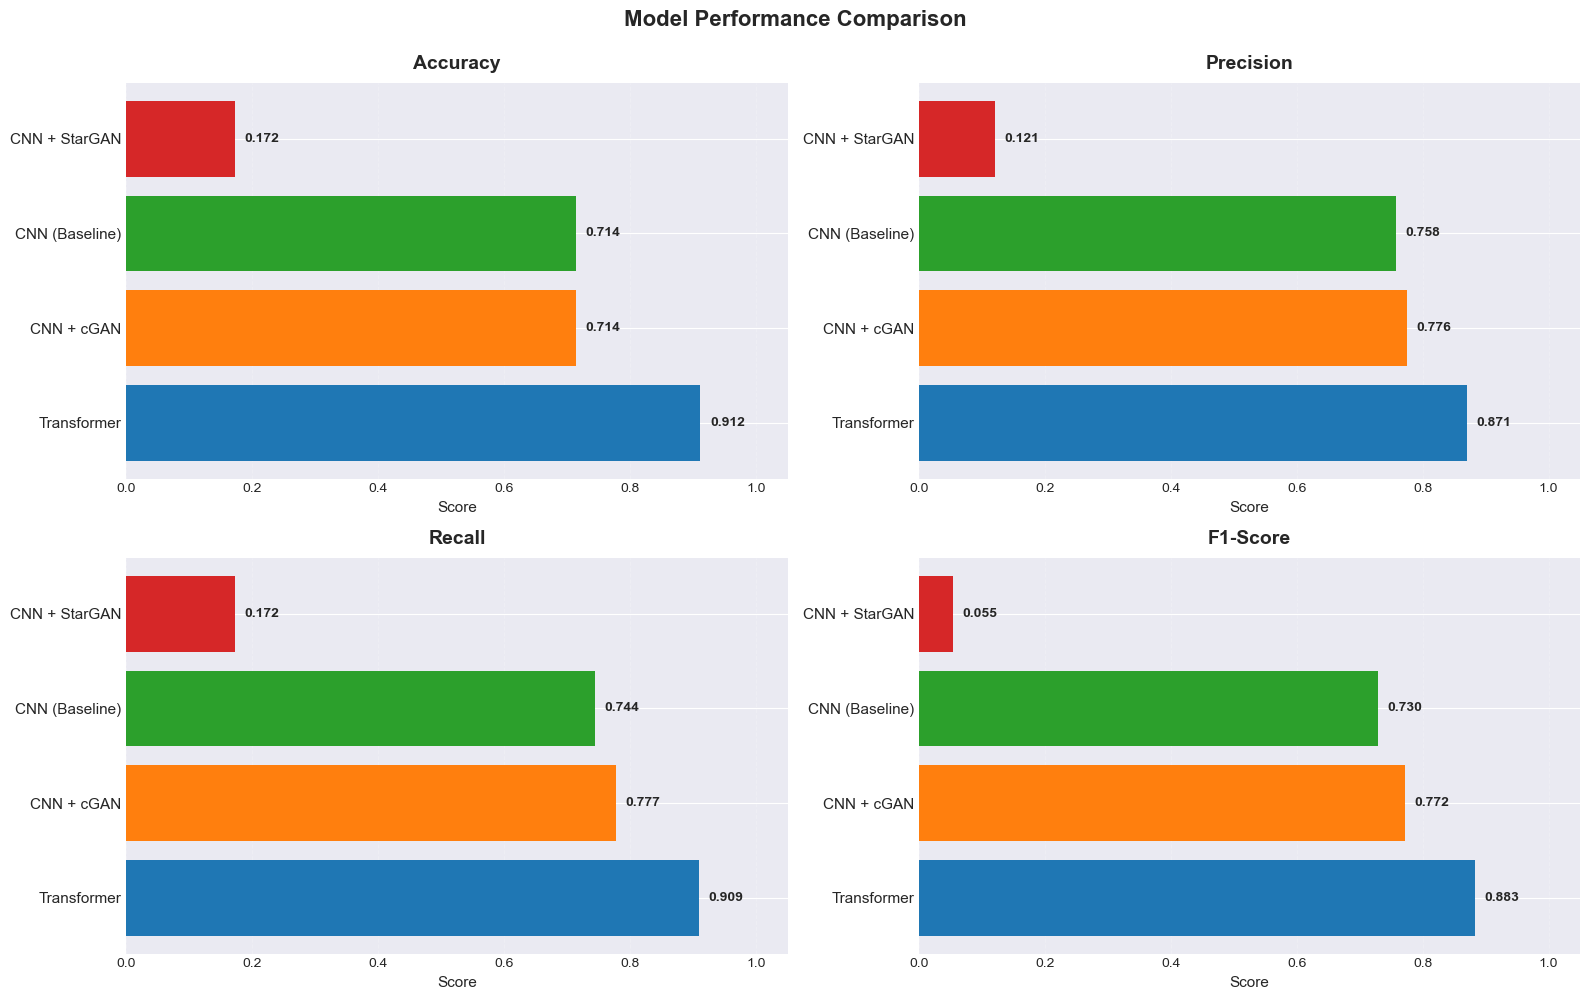

In [11]:
if all_metrics and len(all_metrics) > 0:
    # Create comprehensive comparison visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    # Individual metric plots
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx]
        
        data = metrics_df[metric].sort_values(ascending=False)
        bars = ax.barh(range(len(data)), data.values, color=colors)
        ax.set_yticks(range(len(data)))
        ax.set_yticklabels(data.index, fontsize=11)
        ax.set_xlabel('Score', fontsize=11)
        ax.set_title(f'{metric}', fontsize=14, fontweight='bold', pad=10)
        ax.set_xlim([0, 1.05])
        ax.grid(axis='x', alpha=0.2, linestyle='--')
        
        # Add value labels only at the end of bars
        for i, (idx_val, value) in enumerate(data.items()):
            ax.text(value + 0.015, i, f'{value:.3f}',
                   ha='left', va='center', fontsize=10, fontweight='bold')
    
    plt.suptitle('Model Performance Comparison', 
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    
    # Save figure
    output_path = comparison_root / 'model_comparison_metrics.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\nComparison plot saved to {output_path}")
    plt.show()
else:
    print("Not enough data to create comparison plots")

## 5. Per-Class Performance Analysis

✓ CNN + cGAN: Per-class metrics loaded

CNN + cGAN - Per-Class Performance
    Soil Type  Precision   Recall  F1-Score  Correct  Total  Accuracy (%)
Alluvial_Soil   0.500000 0.300000  0.375000        3     10     30.000000
    Arid_Soil   0.775862 0.789474  0.782609       45     57     78.947368
   Black_Soil   0.816667 0.960784  0.882883       49     51     96.078431
Laterite_Soil   0.693878 0.772727  0.731183       34     44     77.272727
Mountain_Soil   0.848485 0.700000  0.767123       28     40     70.000000
     Red_Soil   0.800000 0.727273  0.761905       16     22     72.727273
  Yellow_Soil   0.833333 0.714286  0.769231       10     14     71.428571

Per-class performance plot saved to ..\results\comparison\per_class_performance.png


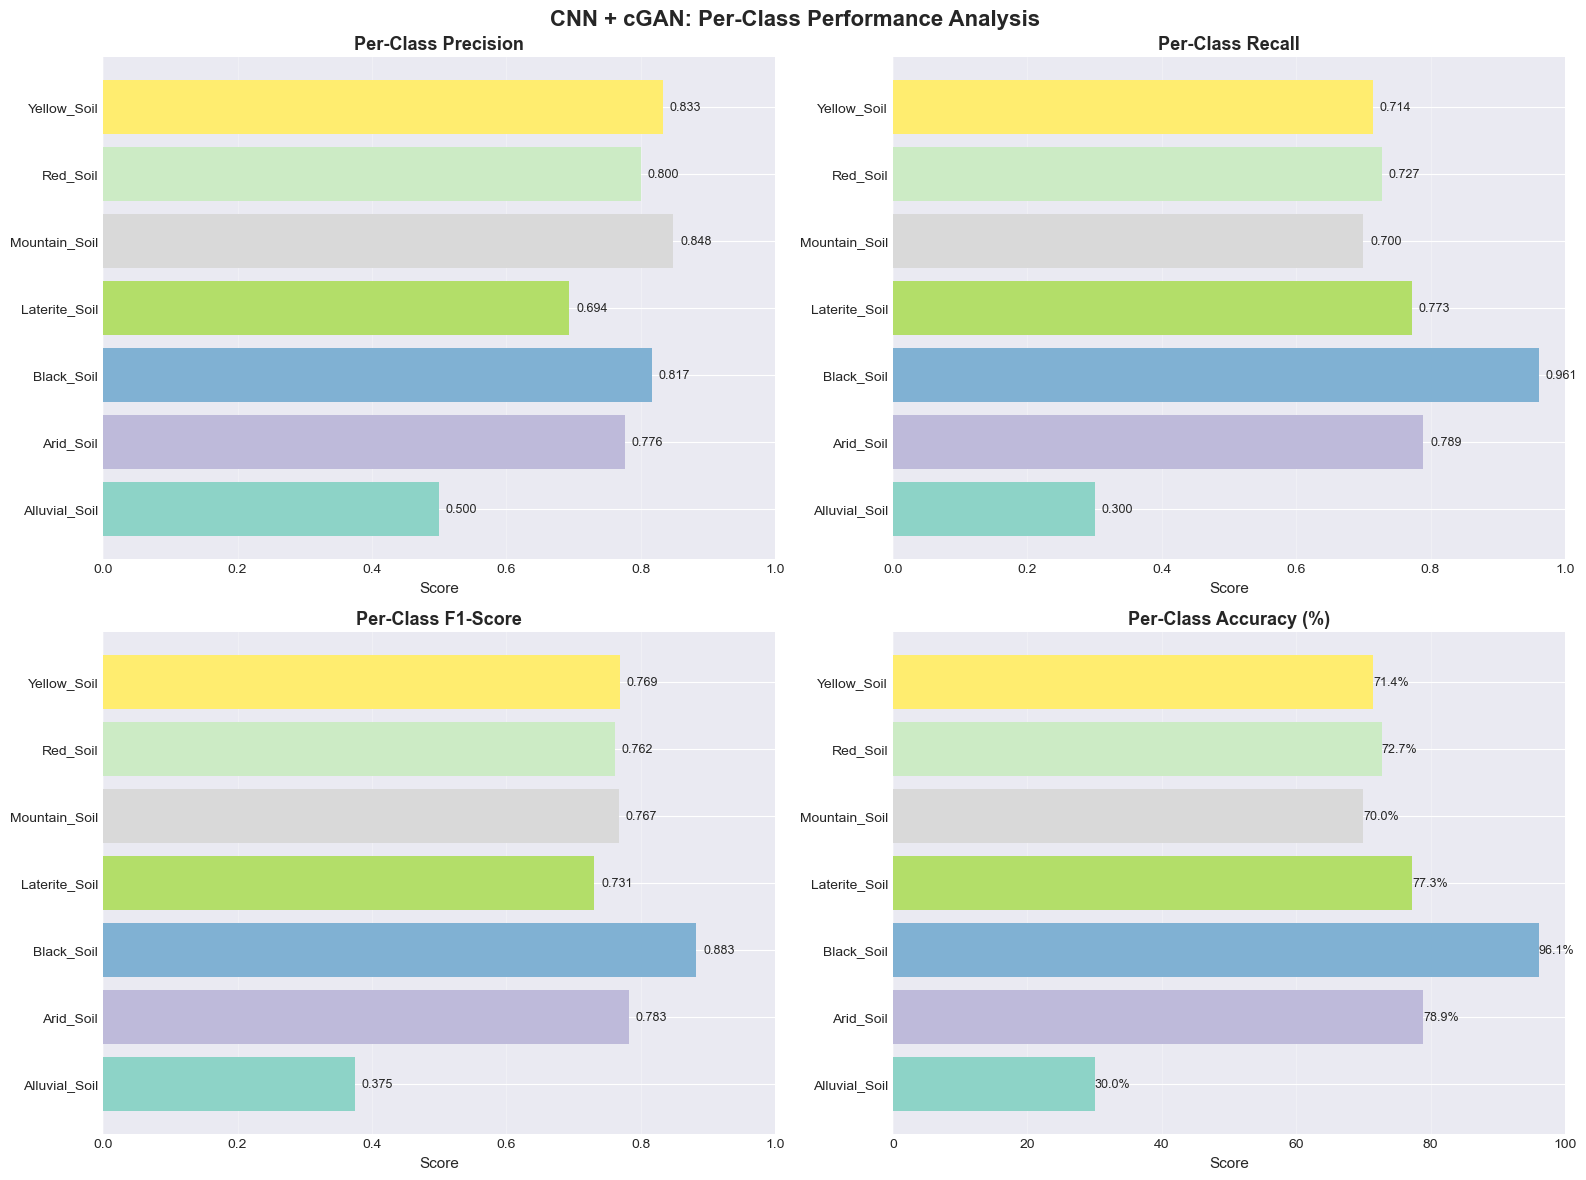

In [7]:
# Load per-class metrics for available models
per_class_data = {}

# Load GAN per-class metrics
gan_per_class_path = available_models.get('GAN') / 'per_class_metrics.csv' if available_models.get('GAN') else None
if gan_per_class_path and gan_per_class_path.exists():
    gan_df = pd.read_csv(gan_per_class_path)
    per_class_data['CNN + cGAN'] = gan_df
    print(f"✓ CNN + cGAN: Per-class metrics loaded")

# Display per-class comparison if available
if per_class_data:
    for model_name, df in per_class_data.items():
        print(f"\n{'='*80}")
        print(f"{model_name} - Per-Class Performance")
        print('='*80)
        print(df.to_string(index=False))
        print('='*80)
    
    # Create per-class visualization
    if 'CNN + cGAN' in per_class_data:
        df = per_class_data['CNN + cGAN']
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy (%)']
        colors_palette = plt.cm.Set3(np.linspace(0, 1, len(df)))
        
        for idx, metric in enumerate(metrics):
            ax = axes[idx]
            
            if metric in df.columns:
                bars = ax.barh(df['Soil Type'], df[metric], color=colors_palette)
                ax.set_xlabel('Score', fontsize=11)
                ax.set_title(f'Per-Class {metric}', fontsize=13, fontweight='bold')
                
                # Add value labels
                for i, (bar, val) in enumerate(zip(bars, df[metric])):
                    width = bar.get_width()
                    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2.,
                           f'{val:.3f}' if metric != 'Accuracy (%)' else f'{val:.1f}%',
                           ha='left', va='center', fontsize=9)
                
                ax.grid(axis='x', alpha=0.3)
                if metric == 'Accuracy (%)':
                    ax.set_xlim([0, 100])
                else:
                    ax.set_xlim([0, 1.0])
        
        plt.suptitle('CNN + cGAN: Per-Class Performance Analysis', 
                     fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        output_path = comparison_root / 'per_class_performance.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"\nPer-class performance plot saved to {output_path}")
        plt.show()
else:
    print("No per-class metrics available")

✓ CNN (Baseline): Confusion matrix loaded
✓ CNN + cGAN: Confusion matrix loaded

Total confusion matrices loaded: 2

Combined confusion matrices saved to ..\results\comparison\all_confusion_matrices.png


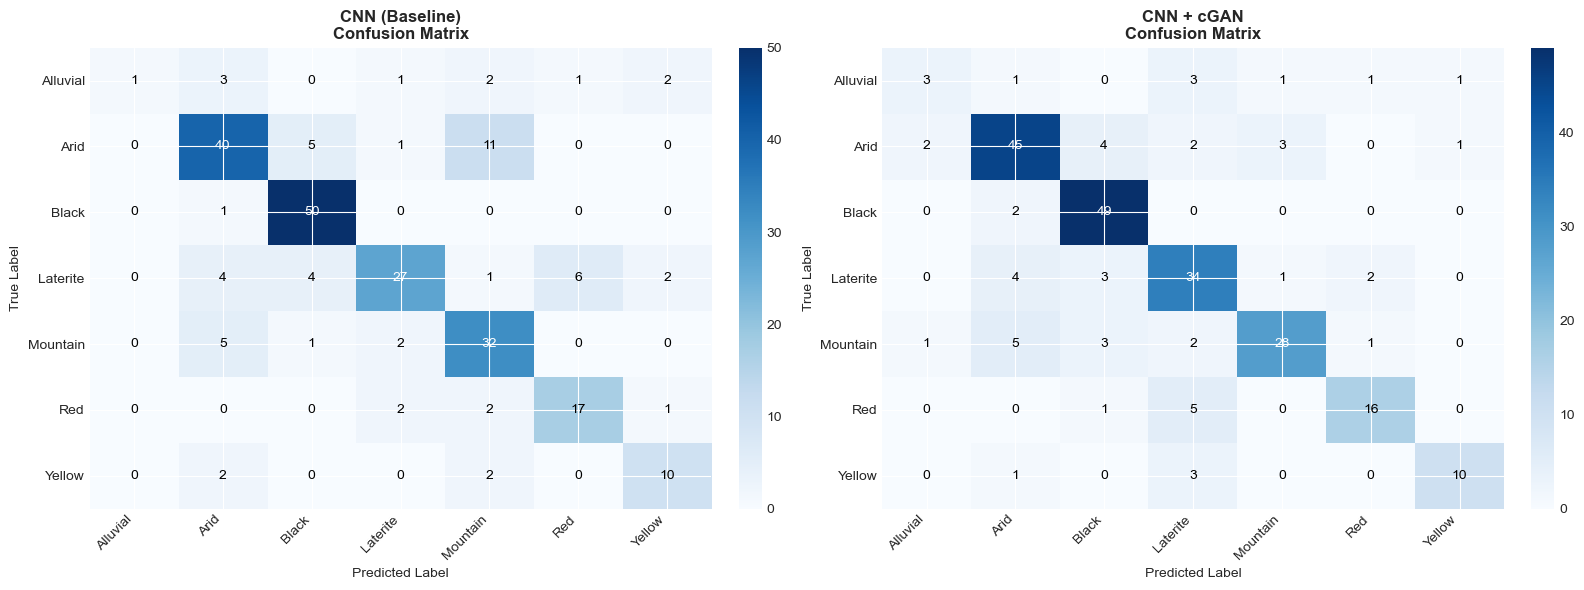

In [8]:
# Load confusion matrices
confusion_matrices = {}
class_names = ['Alluvial', 'Arid', 'Black', 'Laterite', 'Mountain', 'Red', 'Yellow']

# Load CNN confusion matrix
cnn_cm_path = available_models.get('CNN') / 'confusion_matrix.npy' if available_models.get('CNN') else None
if cnn_cm_path and cnn_cm_path.exists():
    confusion_matrices['CNN (Baseline)'] = np.load(cnn_cm_path)
    print(f"✓ CNN (Baseline): Confusion matrix loaded")

# Load GAN confusion matrix
gan_cm_path = available_models.get('GAN') / 'confusion_matrix.csv' if available_models.get('GAN') else None
if gan_cm_path and gan_cm_path.exists():
    confusion_matrices['CNN + cGAN'] = pd.read_csv(gan_cm_path, index_col=0).values
    print(f"✓ CNN + cGAN: Confusion matrix loaded")

# For StarGAN and Transformer, try to extract from images or create from per-class metrics
print(f"\nTotal confusion matrices loaded: {len(confusion_matrices)}")

# Plot all confusion matrices
if confusion_matrices:
    n_models = len(confusion_matrices)
    fig, axes = plt.subplots(1, n_models, figsize=(8*n_models, 6))
    if n_models == 1:
        axes = [axes]
    
    for idx, (model_name, cm) in enumerate(confusion_matrices.items()):
        ax = axes[idx]
        
        # Plot confusion matrix
        im = ax.imshow(cm, cmap='Blues', aspect='auto')
        
        # Set ticks and labels
        ax.set_xticks(np.arange(len(class_names)))
        ax.set_yticks(np.arange(len(class_names)))
        ax.set_xticklabels(class_names, rotation=45, ha='right')
        ax.set_yticklabels(class_names)
        
        # Add text annotations
        for i in range(len(class_names)):
            for j in range(len(class_names)):
                text = ax.text(j, i, int(cm[i, j]),
                             ha="center", va="center", color="white" if cm[i, j] > cm.max()/2 else "black",
                             fontsize=10)
        
        ax.set_title(f'{model_name}\nConfusion Matrix', fontsize=12, fontweight='bold')
        ax.set_ylabel('True Label', fontsize=10)
        ax.set_xlabel('Predicted Label', fontsize=10)
        
        # Add colorbar
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    
    # Save figure
    output_path = comparison_root / 'all_confusion_matrices.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"\nCombined confusion matrices saved to {output_path}")
    plt.show()
else:
    print("No confusion matrices available for comparison")

## 7. Summary Report

In [9]:
# Generate comprehensive summary report
if all_metrics:
    report_path = comparison_root / 'comparison_summary.txt'
    
    with open(report_path, 'w') as f:
        f.write("="*80 + "\n")
        f.write("COMPREHENSIVE MODEL COMPARISON REPORT\n")
        f.write("="*80 + "\n\n")
        
        f.write("Models Evaluated:\n")
        f.write("-" * 80 + "\n")
        for model_name in all_metrics.keys():
            f.write(f"  - {model_name}\n")
        f.write("\n")
        
        f.write("Performance Metrics:\n")
        f.write("-" * 80 + "\n")
        f.write(metrics_df.to_string())
        f.write("\n\n")
        
        # Best performing model per metric
        f.write("Best Performing Models by Metric:\n")
        f.write("-" * 80 + "\n")
        for metric in metrics_df.columns:
            best_model = metrics_df[metric].idxmax()
            best_score = metrics_df[metric].max()
            f.write(f"  {metric:15s}: {best_model:20s} ({best_score:.4f})\n")
        
        f.write("\n")
        
        # Improvement analysis
        if 'CNN (Baseline)' in metrics_df.index:
            f.write("Improvement Analysis (vs CNN Baseline):\n")
            f.write("-" * 80 + "\n")
            baseline = metrics_df.loc['CNN (Baseline)']
            
            for model in metrics_df.index:
                if model != 'CNN (Baseline)':
                    f.write(f"\n{model}:\n")
                    for metric in metrics_df.columns:
                        improvement = ((metrics_df.loc[model, metric] - baseline[metric]) / baseline[metric]) * 100
                        sign = "+" if improvement >= 0 else ""
                        f.write(f"  {metric:15s}: {sign}{improvement:6.2f}%\n")
        
        f.write("\n")
        f.write("="*80 + "\n")
        
        # Overall recommendation
        if 'Accuracy' in metrics_df.columns:
            best_overall = metrics_df['Accuracy'].idxmax()
            best_acc = metrics_df['Accuracy'].max()
            f.write(f"\nRECOMMENDATION:\n")
            f.write(f"  {best_overall} shows the best overall accuracy ({best_acc:.4f})\n")
            
            # Check if it's also best in other metrics
            best_count = sum(metrics_df[col].idxmax() == best_overall for col in metrics_df.columns)
            f.write(f"  This model achieves the best score in {best_count}/{len(metrics_df.columns)} metrics.\n")
        
        f.write("\n" + "="*80 + "\n")
        
        # Additional insights
        f.write("\nKEY INSIGHTS:\n")
        f.write("-" * 80 + "\n")
        
        # Compare augmentation approaches
        if 'CNN + cGAN' in metrics_df.index and 'CNN + StarGAN' in metrics_df.index:
            f.write("\nData Augmentation Comparison:\n")
            cgan_avg = metrics_df.loc['CNN + cGAN'].mean()
            stargan_avg = metrics_df.loc['CNN + StarGAN'].mean()
            if cgan_avg > stargan_avg:
                f.write(f"  - cGAN augmentation outperforms StarGAN (avg: {cgan_avg:.4f} vs {stargan_avg:.4f})\n")
            else:
                f.write(f"  - StarGAN augmentation outperforms cGAN (avg: {stargan_avg:.4f} vs {cgan_avg:.4f})\n")
        
        # Compare architectures
        if 'Transformer' in metrics_df.index and 'CNN (Baseline)' in metrics_df.index:
            f.write("\nArchitecture Comparison:\n")
            trans_avg = metrics_df.loc['Transformer'].mean()
            cnn_avg = metrics_df.loc['CNN (Baseline)'].mean()
            if trans_avg > cnn_avg:
                improvement = ((trans_avg - cnn_avg) / cnn_avg) * 100
                f.write(f"  - Transformer outperforms CNN baseline by {improvement:.2f}% on average\n")
            else:
                decrease = ((cnn_avg - trans_avg) / cnn_avg) * 100
                f.write(f"  - CNN baseline performs {decrease:.2f}% better than Transformer on average\n")
        
        f.write("\n" + "="*80 + "\n")
    
    print(f"\nComprehensive summary report saved to {report_path}")
    
    # Display the report
    with open(report_path, 'r') as f:
        print("\n" + f.read())
else:
    print("No metrics available to generate summary report")


Comprehensive summary report saved to ..\results\comparison\comparison_summary.txt

COMPREHENSIVE MODEL COMPARISON REPORT

Models Evaluated:
--------------------------------------------------------------------------------
  - CNN (Baseline)
  - CNN + cGAN
  - CNN + StarGAN
  - Transformer

Performance Metrics:
--------------------------------------------------------------------------------
                Accuracy  Precision    Recall  F1-Score
Transformer     0.911800   0.870800  0.909100  0.882600
CNN + cGAN      0.714286   0.775700  0.777300  0.772200
CNN (Baseline)  0.714286   0.758282  0.743697  0.729815
CNN + StarGAN   0.172222   0.120538  0.172222  0.054729

Best Performing Models by Metric:
--------------------------------------------------------------------------------
  Accuracy       : Transformer          (0.9118)
  Precision      : Transformer          (0.8708)
  Recall         : Transformer          (0.9091)
  F1-Score       : Transformer          (0.8826)

Improvement A

## 8. Export Results to CSV

In [10]:
# Save metrics to CSV for further analysis
if all_metrics:
    csv_path = comparison_root / 'model_comparison.csv'
    metrics_df.to_csv(csv_path)
    print(f"\nMetrics exported to {csv_path}")
    print("\nYou can now use this CSV file for further analysis or reporting.")
else:
    print("No metrics to export")


Metrics exported to ..\results\comparison\model_comparison.csv

You can now use this CSV file for further analysis or reporting.
